# Bayesian linear regression: Impact of prior variance

To learn more about Bayesian linear regression, see Bishop "Pattern Recognition and Machine Learning".

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
from bayesian_linear_regression_empirical_bayes import EmpiricalBayesUnknownObservationNoise
from utils import expand, polynomial_basis_function, kl_divergence_multivariate_gaussians


plt.style.use("seaborn-whitegrid")

Set up function to approximate.

In [2]:
f_w0 = -0.3
f_w1 =  0.5


def f(X, noise_variance):
    '''Linear function plus noise'''
    return f_w0 + f_w1 * X + noise(X.shape, noise_variance)


def g(X, noise_variance):
    '''Sinus function plus noise'''
    return 0.5 + np.sin(2 * np.pi * X) + noise(X.shape, noise_variance)


def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

## Interactive visualization

<IPython.core.display.Javascript object>


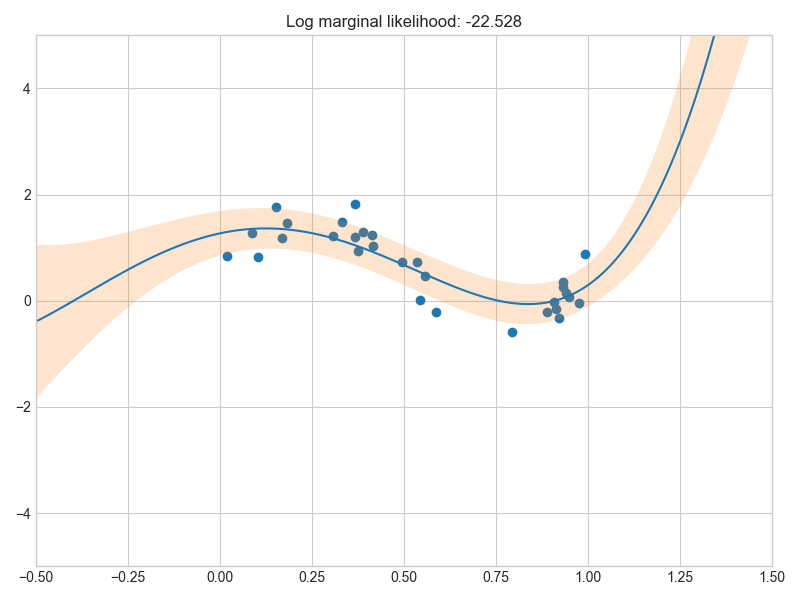

interactive(children=(IntSlider(value=30, continuous_update=False, description='num_train_samples', layout=Lay…

<function __main__.display_estimates(num_train_samples, alpha)>

In [4]:
degree = 4
# Test range
xs = np.linspace(-1.0, 2.0, 1000).reshape(-1, 1)
Phi_test = expand(xs, bf=polynomial_basis_function, bf_args=range(1, degree + 1)) 

fig_interactive, ax_interactive = plt.subplots(1, 1, figsize=(8, 6))

def display_estimates(num_train_samples, alpha):
    ax_interactive.clear()
    
    # Set up training examples
    np.random.seed(91058)
    X_train = np.random.rand(num_train_samples, 1)
    t_train = g(X_train, noise_variance=0.3 ** 2)
    Phi_train = expand(X_train, bf=polynomial_basis_function, bf_args=range(1, degree + 1))
    
    # Fit Bayesian linear regression model
    reg = EmpiricalBayesUnknownObservationNoise(alpha)
    reg.fit(Phi_train, t_train.ravel(), verbose=False)
    log_marginal_likelihood = reg.log_marginal_likelihood(Phi_train, t_train.ravel())
    
    y_test, y_var_test = reg.predict(Phi_test)
    
    ax_interactive.scatter(X_train, t_train)
    ax_interactive.plot(xs, y_test)
    ax_interactive.fill_between(xs.ravel(), (y_test - np.sqrt(y_var_test)).flatten(), (y_test + np.sqrt(y_var_test)).flatten(), alpha=0.2)
    
    ax_interactive.set_xlim([-0.5, 1.5])
    ax_interactive.set_ylim([-5, 5])
    
    ax_interactive.set_title("Log marginal likelihood: {:4.3f}".format(log_marginal_likelihood))
    
    fig_interactive.tight_layout()


interact(display_estimates,
         num_train_samples=widgets.IntSlider(min=10, max=100, value=30, continuous_update=False, layout=widgets.Layout(width='90%')),
         alpha=widgets.FloatLogSlider(min=-5, max=3, value=0.1, continuous_update=False, layout=widgets.Layout(width='90%')),)

## How do $\alpha$ and $\beta$ enter the equation?

**Note that these are the results for fixed values of $\alpha$ and $\beta$, no fully Bayesian treatment.**

* $\alpha > 0.1$: Predictions become worse
* $\alpha \rightarrow 0$: Predictive variance inflates => Higher predictive uncertainty, but lower log marginal likelihood
* Also note that the predictive variance appears to be lopsided

The predictive distribution is given by

$$
p(t \lvert \mathbf{x}, \mathbf{t}, \alpha, \beta) = 
\mathcal{N}(t \lvert \mathbf{m}_N^T \boldsymbol\phi(\mathbf{x}), \sigma_N^2(\mathbf{x})) \tag{15}
$$

where mean $\mathbf{m}_N^T \boldsymbol\phi(\mathbf{x})$ is the regression function after $N$ observations and $\sigma_N^2(\mathbf{x})$ is the corresponding predictive variance

$$
\sigma_N^2(\mathbf{x}) = {1 \over \beta} + \boldsymbol\phi(\mathbf{x})^T \mathbf{S}_N \boldsymbol\phi(\mathbf{x}) \tag{16}
$$

The posterior distribution over the weights is given as follows:

$$
\begin{align*}
\mathbf{m}_N &= \beta \mathbf{S}_N \boldsymbol\Phi^T \mathbf{t}  \tag{9} \\
\mathbf{S}_N^{-1} &= \alpha\mathbf{I} + \beta \boldsymbol\Phi^T \boldsymbol\Phi  \tag{10}
\end{align*}
$$

## Draw posterior and prior over the weights as a function of $\alpha$

<IPython.core.display.Javascript object>


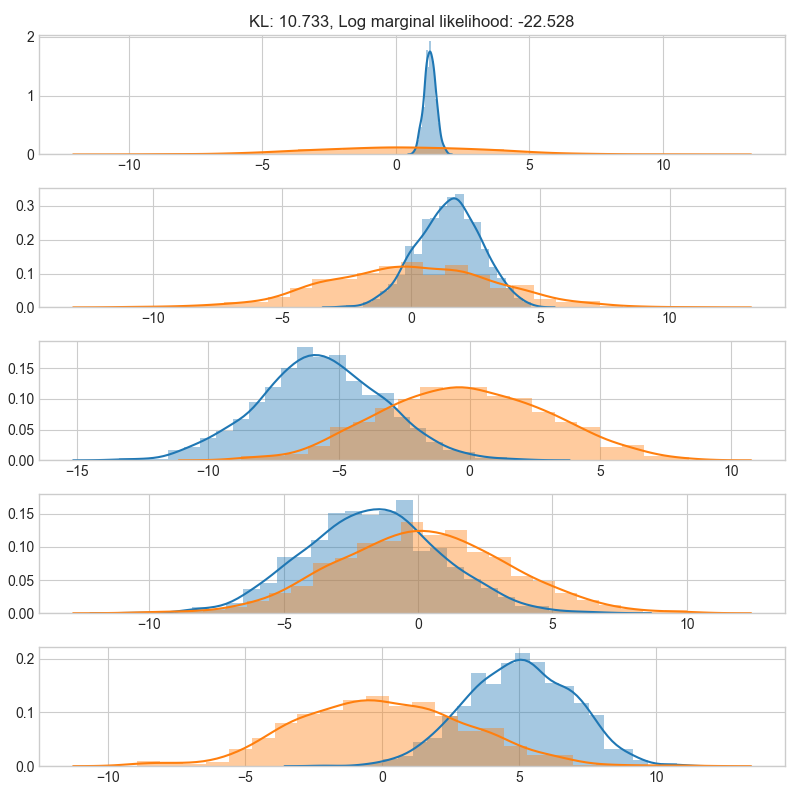

interactive(children=(IntSlider(value=30, continuous_update=False, description='num_train_samples', layout=Lay…

<function __main__.display_posteriors(num_train_samples, alpha)>

In [5]:
degree = 4
# Test range
xs = np.linspace(-1.0, 2.0, 1000).reshape(-1, 1)
Phi_test = expand(xs, bf=polynomial_basis_function, bf_args=range(1, degree + 1)) 

num_dims = degree + 1
fig, axes = plt.subplots(num_dims, 1, figsize=(8, 8))

def display_posteriors(num_train_samples, alpha):
    # Set up training examples
    np.random.seed(91058)
    X_train = np.random.rand(num_train_samples, 1)
    t_train = g(X_train, noise_variance=0.3 ** 2)
    Phi_train = expand(X_train, bf=polynomial_basis_function, bf_args=range(1, degree + 1))
    
    # Fit variational approximation
    reg = EmpiricalBayesUnknownObservationNoise(alpha)
    reg.fit(Phi_train, t_train.ravel(), verbose=False)
    log_marginal_likelihood = reg.log_marginal_likelihood(Phi_train, t_train.ravel())
    
    for dim in range(num_dims):
        axes[dim].clear()
        
        # Draw the posterior for this dimension
        mean = reg._m_N[dim]
        scale = np.sqrt(reg._S_N[dim, dim])
        
        data = np.random.normal(loc=mean, scale=scale, size=1000)
        sns.distplot(data, ax=axes[dim])
        
        # Draw the prior for this dimension
        mean = 0
        scale = np.sqrt(1. / alpha)
        data = np.random.normal(loc=mean, scale=scale, size=1000)
        sns.distplot(data, ax=axes[dim])
        
        # Compute the KL divergence
    
    kl_div = kl_divergence_multivariate_gaussians(reg._m_N, np.zeros_like(reg._m_N), reg._S_N, np.eye(num_dims) / alpha)
    axes[0].set_title("KL: {:4.3f}, Log marginal likelihood: {:4.3f}".format(kl_div, log_marginal_likelihood))
    fig.tight_layout()


interact(display_posteriors,
         num_train_samples=widgets.IntSlider(min=10, max=100, value=30, continuous_update=False, layout=widgets.Layout(width='90%')),
         alpha=widgets.FloatLogSlider(min=-5, max=3, value=0.1, continuous_update=False, layout=widgets.Layout(width='90%')),)

As $\alpha$ increases, i.e., the prior becomes more peaked, the KL divergence decreases. However, the log marginal likelihood decreases.

## Scaling of complexity and likelihood cost

From the derivation of the **evidence lower bound** (ELBO):

\begin{align}
\text{KL}[q(\mathbf{w} | \mathbf{\theta}) || p(\mathbf{w} | \mathcal{D})] &= \text{KL}[q(\mathbf{w} | \mathbf{\theta}) || p(\mathbf{w})] - \mathbb{E}_{q(\mathbf{w} | \mathbf{\theta})} [\log p(\mathcal{D} | \mathbf{w}) ] + \log p(\mathcal{D}) \tag{1}\\
&= -\mathcal{L}(\mathcal{D}, \mathbf{\theta}) + \log p(\mathcal{D}) \tag{2}
\end{align}

The ELBO is a lower bound on $\log p(\mathcal{D})$ because the KL divergence is always non-negative.

\begin{align}
\mathcal{L}(\mathcal{D}, \mathbf{\theta}) &= \log p(\mathcal{D}) - \text{KL} [q(\mathbf{w} | \mathbf{\theta}) || p(\mathbf{w} | \mathcal{D})] \\
\mathcal{L}(\mathcal{D}, \mathbf{\theta}) &\leq \log p(\mathcal{D})
\end{align}

To train a Bayesian neural network, we minimize the negative ELBO $-\mathcal{L}(\mathcal{D}, \mathbf{\theta})$, which is composed of the divergence from the prior and the negative log likelihood.

\begin{align}
\mathbf{\theta^*} = \arg \min_{\mathbf{\theta}} \quad \underbrace{\text{KL}[q(\mathbf{w} | \mathbf{\theta}) || p(\mathbf{w})]}_{\text{complexity cost}} \quad \underbrace{- \mathbb{E}_{q(\mathbf{w} | \mathbf{\theta})} [\log p(\mathcal{D} | \mathbf{w}) ]}_{\text{likelihood cost}}
\end{align}

**Likelihood cost**

Under the assumption of independent examples, the log likelihood is

\begin{align}
\log p(\mathcal{D} | \mathbf{w}) &= \log \left[ \prod\limits_{n=1}^N p(y_n | \mathbf{x_n}, \mathbf{w}) \right] \\
&= \sum\limits_{n=1}^N \log \left[ p(y_n | \mathbf{x_n}, \mathbf{w}) \right]
\end{align}

In words, the likelihood cost scales with the number of training examples.

**Complexity cost**

For simplicity, we assume that weights of different layers are independent, i.e., $q(\mathbf{w}) = q(\mathbf{w_1}) q(\mathbf{w_2}) \cdot \dots \cdot q(\mathbf{w_l})$.

As a result, the KL divergence can be decomposed into a sum of $l$ KL divergences. The KL divergence is additive for independent distributions.

\begin{align}
\text{KL}[q(\mathbf{w} | \mathbf{\theta}) || p(\mathbf{w})] &= \text{KL}[q(\mathbf{w}_1 | \mathbf{\theta}_1) q(\mathbf{w}_2 | \mathbf{\theta}_2) \dots || p(\mathbf{w_1}) p(\mathbf{w_2}) \dots] \\
&= \text{KL}[q(\mathbf{w}_1 | \mathbf{\theta}_1) || p(\mathbf{w_1}) ] + \text{KL}[q(\mathbf{w}_2 | \mathbf{\theta}_2) || p(\mathbf{w_2}) ] + \dots
\end{align}

In words, the complexity cost scales with the number of layers.

**Take-home message(?)**: If we do not balance likelihood and complexity costs appropriately, we might end up with a suboptimal lower bound.

## Log marginal likelihood = Expected log likelihood - KL[posterior || prior]

If we find the true posterior, i.e., $q(\mathbf{w} | \mathbf{\theta}) = p(\mathbf{w} | \mathcal{D})$, Equation (1) evaluates to:

\begin{align}
0 &= \text{KL}[p(\mathbf{w} | \mathcal{D}) || p(\mathbf{w})] - \mathbb{E}_{p(\mathbf{w} | \mathcal{D})} [\log p(\mathcal{D} | \mathbf{w}) ] + \log p(\mathcal{D})\\
\log p(\mathcal{D}) &= \mathbb{E}_{p(\mathbf{w} | \mathcal{D})} [\log p(\mathcal{D} | \mathbf{w}) ] - \text{KL}[p(\mathbf{w} | \mathcal{D}) || p(\mathbf{w})]
\end{align}

The log marginal likelihood can be rewritten as the sum of the expected log-likelihood under the true posterior and the negative KL divergence between the posterior and the prior.

In [6]:
def expected_log_likelihood(Phi, t, m_N, S_N, beta):
    """
    Compute expected log-likelihood of given set of samples and targets
    """
    num_samples = len(t)

    # Non-vectorized expression
    #     total = 0
    #     for n in range(num_samples):
    #         total += Phi[n].T @ (np.outer(reg._m_N, reg._m_N) + S_N) @ Phi[n] - 2.0 * m_N @ Phi[n] * t[n] + t[n] ** 2

    total = np.sum(
        np.sum((Phi @ (np.outer(reg._m_N, reg._m_N) + S_N)) * Phi, axis=1)
        - 2. * (Phi @ m_N) * t
        + np.square(t)
    , axis=0)
    
    total = -beta / 2. * total
    total += num_samples / 2. * np.log(beta / (2 * np.pi))
    
    return total

<IPython.core.display.Javascript object>


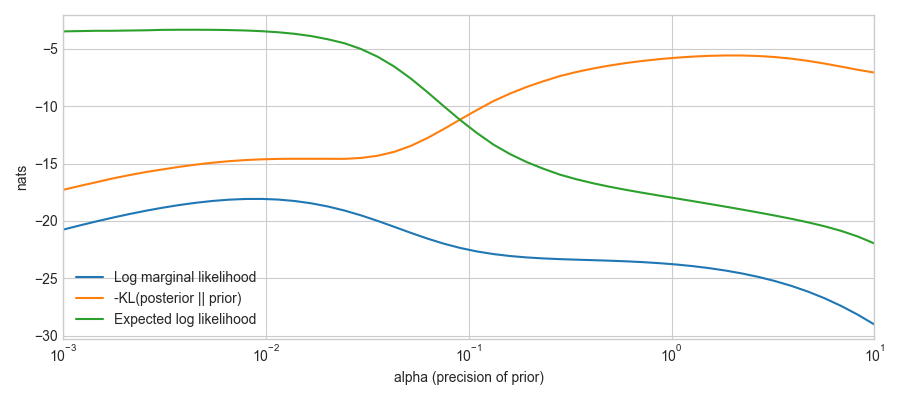

In [7]:
np.random.seed(91058)
num_train_samples = 30
X_train = np.random.rand(num_train_samples, 1)
t_train = g(X_train, noise_variance=0.3 ** 2)
Phi_train = expand(X_train, bf=polynomial_basis_function, bf_args=range(1, degree + 1))

alphas = np.logspace(-3, 1)
log_marginal_likelihoods = []
neg_kl_divergences = []
expected_log_likelihoods = []

# Train different models with different choice of prior
for alpha in alphas:
    # Fit model
    reg = EmpiricalBayesUnknownObservationNoise(alpha)
    reg.fit(Phi_train, t_train.ravel(), verbose=False)
    log_marginal_likelihood = reg.log_marginal_likelihood(Phi_train, t_train.ravel())

    exp_log_like = expected_log_likelihood(Phi_train, t_train.ravel(), reg._m_N, reg._S_N, reg._beta)
    neg_kl_div = -kl_divergence_multivariate_gaussians(reg._m_N, np.zeros_like(reg._m_N), reg._S_N, np.eye(num_dims) / alpha)
    
    log_marginal_likelihoods.append(log_marginal_likelihood)
    expected_log_likelihoods.append(np.sum(exp_log_like))
    neg_kl_divergences.append(neg_kl_div)

# Visualization
fig, ax = plt.subplots(figsize=(9, 4))
ax.set_xscale("log")
ax.set_xlabel("alpha (precision of prior)")
ax.set_ylabel("nats")

ax.plot(alphas, log_marginal_likelihoods, label="Log marginal likelihood")
ax.plot(alphas, neg_kl_divergences, label="-KL(posterior || prior)")
ax.plot(alphas, expected_log_likelihoods, label="Expected log likelihood")

assert np.allclose(np.array(neg_kl_divergences) + np.array(expected_log_likelihoods), log_marginal_likelihoods)

ax.set_xlim([alphas[0], alphas[-1]])
ax.legend(loc="best")
fig.tight_layout()